### IMPORT SECTION

In [51]:
#Gül Eda Aydemir
#504201574
#########################
import numpy as np # pip3 install matplotlib
import matplotlib.pyplot as plt # pip3 install matplotlib

import networkx as nx

from networkx import gnm_random_graph, gnp_random_graph, erdos_renyi_graph, scale_free_graph
import networkx.algorithms.community as nx_comm
from networkx.algorithms.smallworld import random_reference

import random
import community # can be installed with: "pip install python-louvain"
from numpy import linalg as LA
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors


### HYPERPARAMETER SECTION


In [52]:
V = 30  # node count
min_p = 0.08 # Specific minimum p value for Erdos-Renyi model
max_p = 0.85 # Specific maximum p value for Erdos-Renyi model

# Erdos-Renyi is a generative model. Maslov-Sneppen algorithm will create rewired variants of the graphs.
graph_count = 30 # to be used for erdös and maslov graphs, seperately
node_draw_size = 75 # Node circle size in plots

seed = 1773 # Seed for all stochastic actions - ITU will bring us luck

## DO NOT CHANGE
np.random.seed(seed)
graph_creation_seed = np.random.randint(seed, size = graph_count*150000) ## for graph_count*150000 creations just in case of creating not connected graphs
graph_creation_seed = [int(i) for i in graph_creation_seed]
max_solver_iterations = 1000000000

### For eye-health 🤡

In [53]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
}  
</style>
""")

import warnings
warnings.filterwarnings("ignore")

In [54]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# START POINT OF THE HOMEWORK

### Creating the Erdos-Renyi graphs and Scale-Free graphs.

In [55]:
## Setting different Erdös-Renyi probabilities to prevent very similar node-degreed graphs
probs = np.linspace(min_p, max_p, num=graph_count)

# Creating a graph array to easily iterate over them
erdos_array = []

seed_i = 0
i = 0

print("Creating Erdös-Renyi graphs..")

while i < graph_count:
    
    temp_graph = erdos_renyi_graph(V, probs[i], seed = graph_creation_seed[seed_i], directed = False)
    
    # The authors said that they guaranteed creating connected graphs during this process
    if nx.is_connected(temp_graph): 
        erdos_array.append(temp_graph.copy())
    else:
        i -= 1 ## try creating again
        
    seed_i += 1 ## changing the seed to create different graph
    i += 1
    
# Creating Scale-Free graphs
print("Creating Scale-Free graphs..")
time.sleep(1)

i = 0
sf_array = []

while i < graph_count:
    
    #creating random graph for 
    RandomG = erdos_renyi_graph(V, min_p, seed = graph_creation_seed[seed_i], directed = False)
    edges = int(RandomG.number_of_edges()/5)
    
    #Random alpha beta gamma values.
    #temp_graph = scale_free_graph(V, alpha=0.01, beta=0.40, gamma=0.59, delta_in=0.5, delta_out=.50, create_using=None, seed = graph_creation_seed[seed_i])
    
    temp_graph = nx.barabasi_albert_graph(V,edges)
    sf_array.append(temp_graph.copy())
    
    seed_i += 1 ## changing the seed to create different graph
    i += 1
    
sf_array = [random_reference(G.copy(), seed = graph_creation_seed[seed_i]) for i,G in enumerate(tqdm(sf_array))]

# Giving random weights to the Erdös-Renyi graphs' links
for G in erdos_array:
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = random.randint(1, 10)
        
# Giving fixed weights (1) to the Scale-Free Graph
for G in sf_array:
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = 1
        
print("Done creating graphs.")

Creating Erdös-Renyi graphs..
Creating Scale-Free graphs..


100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.03it/s]

Done creating graphs.


## Part A: Simulate exponential and free-scale networks

### 1. Briefly explain how the weighted Erdos-Renyi generative model works.

The weigthed Erdos-Renyi model (Weighted Random Model) creates an undirected weighted graph with given node count $n$ and probability $q$($w$)∈[0,1] where $w$ is a weight(i.e., a number of $w$ of links) that presents between any pair of vertices is $q(w)=q^w.(1-p)$ 


### 2. What are the key properties of weighted Erdos-Renyi (ER) graphs?

The weighted Erdos-Renyi graphs can be described analytically by the connection probability $p_{ij} = x_ix_j/(1 + x_ix_j)$, where each parameter $x_i$ allows to control the expected degree $\langle k_i\rangle = \sum_{i\neq j}p_{ij}$ of vertex i. This ensures that all weighted Erdos-Renyi graphs with the same degree sequence $\{k_i\}
^N_{i=1}$ are equiprobable.

### 3. Briefly explain how weighted scale-free (SF) algorithm works.



The detailed model construction algorithm is described by Li Tan and Dingyou Lei(*) as follows, which is applicable to many other scale free types of complex networks;

(i) Initialization. 
    
   The initial network, denoted as $G_0$, is a complete graph with $n$ vertices, which are denoted by $v_{01} , v_{02} ,..., v_{0n}$ . The weight of each link is assigned $w_0 (w_0 \geq v_{01})$ .

(ii) Growth. 

   To construct $G_{t + 1}$ from $G_t$ ,we add a new vertex $v_{t+1}$ and then add $2m(2m \leq n-1)$  edges between $v_{t+1}$ and vertices of $G_t$. We choose  pairs of vertices $W^{1}_t, W^{1^1}_t, W^{2}_t, W^{2^1}_t, ..., W^{m}_t, W^{m^1}_t$ according to a preferential attachment rule. If $w_{ii^1}(t)$ is the weight between vertices $v_i$ and $v_{i^1}$ in $G_t$, then the vertices $v_i$ and $v_{i^1}$ are selected with probability 
   $\frac{w_{ii^1}(t)}{\sum _ {q , l \in V(G_t)} w_{ql}(t)}$ independently for each vertex pair $i, i^1 \in 1,2,...,m$ .

(*for more) https://www.hindawi.com/journals/jam/2013/902519/

### 4. What are the key properties of weighted SF graphs?

The weighted Scale Free graphs displays power-law behavior for the degree, the strength and the edge weight distribution.


### 5. Visualize two random graphs you simulated (ER and SF).

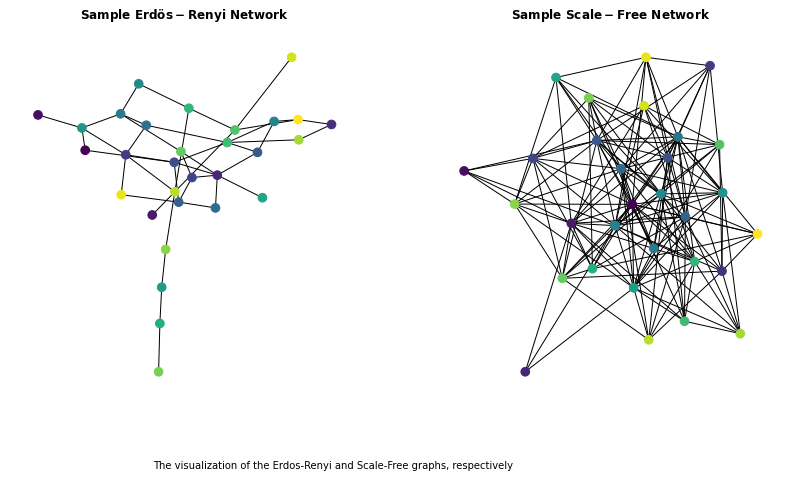

In [56]:
#Implement Part A

sampled_networks = [erdos_array[0], sf_array[0]] # Selecting the first pair of Erdos and Maslov versions

# Creating the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = axes.flatten()
ax[0].title.set_text(r"$\mathbf{Sample\ Erdös-Renyi\ Network}$")
ax[1].title.set_text(r"$\mathbf{Sample\ Scale-Free\ Network}$")

# Iterating in the pair
for i in range(2):
    nx.draw(sampled_networks[i], ax=ax[i], node_color=range(V), node_size=75) # Drawing the graph, assign randomized colors
    ax[i].set_axis_off()
    
# Plotting with the caption
fig.text(.27,0,"The visualization of the Erdos-Renyi and Scale-Free graphs, respectively")
plt.show()

### 6. Plot the overlaid distributions of the node strength centrality for all 30 ER graphs (transparent blue color) and the 30 SF graphs (transparent red color). What do you notice? Interpret your observation.

In [57]:
centralities = []

### Node Strength Centrality

In [58]:
def degree_centrality(G):
    return dict(G.degree(weight = "weight"))

centralities.append(degree_centrality)

### Eigenvector Centrality

In [59]:
def eigenvector_centrality(G):
    return nx.eigenvector_centrality(G, weight = "weight", max_iter = max_solver_iterations)

centralities.append(eigenvector_centrality)

In [60]:
print("We got these centrality functions:", centralities, "\n")
print(len(centralities), "measures total.")

We got these centrality functions: [<function degree_centrality at 0x7fdabfd24040>, <function eigenvector_centrality at 0x7fdabfd243a0>] 

2 measures total.


In [61]:
erdos_centralities = np.zeros((graph_count, len(centralities), V))

for erdos_id, erdos in enumerate(tqdm(erdos_array)):
    for centrality_id, centrality in enumerate(centralities):
        erdos_centralities[erdos_id, centrality_id] = np.nan_to_num(np.array(list(centrality(erdos).values())), 0)

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 150.79it/s]


In [62]:
sf_centralities = np.zeros((graph_count, len(centralities), V))

for sf_id, sf in enumerate(tqdm(sf_array)):
    for centrality_id, centrality in enumerate(centralities):
        sf_centralities[sf_id, centrality_id] = np.nan_to_num(np.array(list(centrality(sf).values())), 0)  

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 222.54it/s]


In [63]:
total_erdos  = np.zeros(graph_count)

for i in range(0,len(erdos_centralities)):
    for j in range(0,len(erdos_centralities[i][0])):
        total_erdos[i] = total_erdos[i] + erdos_centralities[i][0][j]
        
total_erdos = NormalizeData(total_erdos)

total_sf = np.zeros(graph_count)
for i in range(0,len(sf_centralities)):
    for j in range(0,len(sf_centralities[i][0])):
        total_sf[i] = total_sf[i] + sf_centralities[i][0][j]

total_sf = NormalizeData(total_sf)

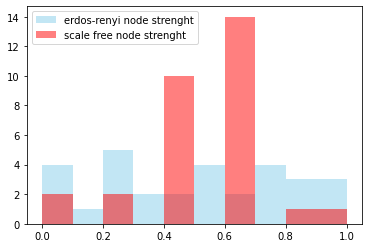

In [64]:
x= plt.hist(total_erdos, label = 'erdos-renyi node strenght', alpha=0.5, color = 'skyblue'  )
plt.legend(loc='best')
##plt.show()
y=plt.hist(total_sf, label = 'scale free node strenght', alpha=0.5, color = 'red')
plt.legend(loc='best')
plt.show()

In Erdos-Renyi, there are outlier centralities. In scale free it is uniform. 

### 7. Plot the overlaid distributions of the eigenvector centrality for all 30 ER graphs (transparent blue color) and the 30 SF graphs (transparent red color). What do you notice? Interpret your observation.

In [65]:
total_eigen_erdos  = np.zeros(graph_count)

for i in range(0,len(erdos_centralities)):
    for j in range(0,len(erdos_centralities[i][1])):
        total_eigen_erdos[i] = total_eigen_erdos[i] + erdos_centralities[i][0][j]

total_eigen_erdos = NormalizeData(total_eigen_erdos)

total_eigen_sf = np.zeros(graph_count)

for i in range(0,len(sf_centralities)):
    for j in range(0,len(sf_centralities[i][1])):
        total_eigen_sf[i] = total_eigen_sf[i] + sf_centralities[i][0][j]

total_eigen_sf = NormalizeData(total_eigen_sf)

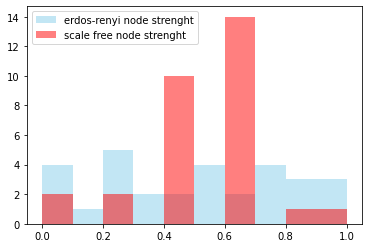

In [66]:
x= plt.hist(total_eigen_erdos, label = 'erdos-renyi node strenght', alpha=0.5, color = 'skyblue'  )
plt.legend(loc='best')
y=plt.hist(total_eigen_sf, label = 'scale free node strenght', alpha=0.5, color = 'red')
plt.legend(loc='best')
plt.show()

The result is same with small changes. Eigenvector Centrality algorithm finds the same centralities for Erdos-Renyi and Scale-Free graphs. 

## Part B: Analyzing Erdos-Renyi and Scale-Free graphs in both random error and target attack scenarios

### 1. [10p] Code up a function called ‘findPercolationThreshold’, where you input a positive weighted adjacency matrix and it automatically outputs its percolation threshold fc.
#### Percolation refers to process that occur on a graph as nodes/edges are being added or removed. As we remove nodes/edges from a graph, we find a percolation threshold (pc) at which the network fragments.

     >pc -> large component emerges
     <pc -> fragmentation into multiple smaller components
     
### 2. [5p] Comment out each line of your ‘findPercolationThreshold’ function and add a text box explaining how your algorithm works.

In [67]:
def findPercolationThreshold(weighted_adj_matrix):
    first_node = 0
    last_node = weighted_adj_matrix.getnnz() - 1
     
        
    # returns a contiguous unique flattened array
    probabilities = np.unique(np.ravel(weighted_adj_matrix, order='C'))

    low = 0
    high = len(probabilities)

    #Until probability is not negative
    while high - low > 1:
        i = (high + low)
        prob = probabilities[i]
        copied_array = np.weighted_adj_matrix(array)
        copied_array[copied_array < prob] = 0.0
        graph = nx.from_numpy_matrix(copied_array)
        #if path exists it is a low propobality
        if nx.has_path(graph, first_node, last_node):
            low = i
        else:
            high = i

    return probabilities[low]

##for G in erdos_array:
pc = findPercolationThreshold(nx.adjacency_matrix(erdos_array[0]))
print(pc)

  (0, 7)	2
  (0, 15)	5
  (1, 15)	7
  (2, 26)	10
  (3, 6)	6
  (3, 7)	10
  (3, 8)	5
  (3, 10)	6
  (3, 17)	6
  (3, 22)	6
  (4, 25)	5
  (4, 29)	10
  (5, 7)	7
  (5, 11)	4
  (5, 15)	6
  (5, 26)	2
  (5, 28)	3
  (6, 3)	6
  (6, 9)	7
  (6, 22)	9
  (7, 0)	2
  (7, 3)	10
  (7, 5)	7
  (7, 9)	2
  (7, 20)	6
  :	:
  (20, 13)	2
  (20, 25)	4
  (21, 19)	4
  (21, 26)	4
  (21, 27)	1
  (21, 29)	6
  (22, 3)	6
  (22, 6)	9
  (22, 12)	3
  (23, 18)	2
  (24, 16)	10
  (24, 26)	6
  (25, 4)	5
  (25, 20)	4
  (26, 2)	10
  (26, 5)	2
  (26, 19)	1
  (26, 21)	4
  (26, 24)	6
  (27, 21)	1
  (28, 5)	3
  (28, 9)	4
  (29, 4)	10
  (29, 13)	3
  (29, 21)	6


### 3. [10p] Code up a function called ‘largestConnectedComponent’, where you input a positive weighted adjacency matrix and it automatically outputs (1) the largest connected component graph, (2) its node size S and (3) its diameter d defined as the average of the shortest paths between all pairs of nodes in the large connected component graph.

### 4. [5p] Comment out each line of your ‘largestConnectedComponent’ function and add a text box explaining how your algorithm works.

In [68]:
def largestConnectedComponent(A):
    array = (A.subgraph(c) for c in nx.connected_components(A))
    return array

In [69]:
largestConnectedComponent(erdos_array[0])

<generator object largestConnectedComponent.<locals>.<genexpr> at 0x7fdac3687270>

### 5. [5p] Random failure scenario. Code up a function called ‘randomError’, inputting (1) the graph adjacency matrix and (2) the fraction (between 0 and 1) of nodes to be randomly removed and returns the adjancy matrix graph excluding the removed nodes. Comment out the code and explain in a text box how it works.

### 6. [5p] Target attack scenario. Code up a function called ‘targetAttack’, inputting (1) the graph adjacency matrix and (2) the fraction (between 0 and 1) of nodes to be attacked removed and returns the adjancy matrix graph excluding the re- moved nodes. Note that the nodes to be removed are those with the highest strength. Comment out the code and explain in a text box how it works.

### 7. [5p] Given one random ER network and one random SF network (you select two from your 60 simulated graphs), plot the diameter d of the largest connected component as in Fig. 2 against the fraction of removed nodes in both random error and target attack scenarios. The nodes need to be removed progressively (e.g., remove 0.1, 0.2, until reaching 0.8).
Important note: Watch out for the percolation threshold. You might need to remove a very small fraction of nodes before it breaks (< 0.1). Keep an eye on that. Adjust your fraction step accordingly.
Produce 3 more similar plots for 6 randomly selected ER and SF graphs (3 ER and 3 SF). Totally, you will have 4 plots for pairs of ER and SF networks to compare.

### 8. [5p] What conclusions can you derive about SF and ER networks and their re- silience to random errors and target attacks? Are these conclusions in line with the paper paper[1]?

### 9. [5p] Given one random ER network and one random SF network (you select two from your 60 simulated graphs), plot the size S of the LCC of the largest connected component as in Fig. 3 against the fraction of removed nodes in both random error and target attack scenarios.
Produce 3 more similar plots for 6 randomly selected ER and SF graphs (3 ER and 3 SF). Totally, you will have 4 plots for pairs of ER and SF networks to compare.

### 10. [5p] What conclusions can you derive about SF and ER networks and their re- silience to random errors and target attacks? Are these conclusions in line with the paper paper[1]?

### 11. [5p] Plot the percolation threshold for each of the 8 sampled graphs using your ‘findPercolationThreshold’ function. Are those thresholds concordents with what we observe in the plots you generated. Discuss and compare.
Comparing ER against FS percolation thresholds for the 8 randomly selected networks, what conclusions can you derive?